# __Chapter 2: From rainfall to runoff__

## Overview
__[Overview](#Overview)__ &nbsp; &nbsp; [2.1 Dynamic soil moisture](#2.1-Dynamic-soil-moisture) &nbsp; &nbsp; [2.2 Coupling Landlab components](#2.2-Coupling-Landlab-components) &nbsp; &nbsp; [2.3 Routing surface water](#2.3-Routing-surface-water) &nbsp; &nbsp; [Definitions](#Definitions)

<div class="alert alert-block alert-info">
    <font size=5><b>Learning Outcomes</b></font>
    <details closed>
    <summary>1. Use Landlab to <b><i>generate</i></b> and <b><i>interpret</i></b> a numerical model of surface water hydrology.</summary>
    <ul><li>Create a model grid in Landlab and add fields to it.</li>
    <li>Combine multiple Landlab components together to build a numerical model.</li>
    <li>Save model states to visualize data using maps and graphs.</li>
    </ul>
    </details>
    <details closed>
    <summary> 2. After raining on the surface, <b><i>explain</i></b> how root zone soil moisture evolves through time.</summary>
    <ul><li>Use the <a href="https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html"><i>SoilMoisture</i></a> component to calculate soil moisture and saturation-excess runoff.</li>
    <li>Visualize soil water retention curves using matplotlib. </li>
    <li>Compare the soil moisture response for two different plant functional types.</li>
    </ul>
    </details>
    <details closed>
    <summary> 3. <b><i>Plan</i></b> and <b><i>excecute</i></b> a model that couples two Landlab components.</summary>
    <ul><li>Use the <a href="https://landlab.readthedocs.io/en/latest/reference/components/uniform_precip.html"><i>PrecipitationDistribution</i></a> component as a rainfall generator in your numerical model.</li>
    <li>Couple the hourly rainfall generator to the daily <a href="https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html"><i>SoilMoisture</i></a> component to simulate soil moisture and runoff dynamics.</li>
    <li>Save results from model runs into a pandas dataframe to synthesize findings.</li>
    </ul>
    </details>
    <details closed>
    <summary> 4. Add topography to <b><i>produce</i></b> and <b><i>critique</i></b> a revised soil water model that also routes runoff across the surface.</summary>
    <ul><li>Apply <a href="https://landlab.readthedocs.io/en/latest/reference/components/flow_director.html"><i>FlowDirectorSteepest</i></a> using the topographic elevation field.</li>
    <li>Accumulate surface water downstream using the <a href="https://landlab.readthedocs.io/en/latest/reference/components/flow_accum.html"><i>FlowAccumulator</i></a> component as an additional source of soil moisture.</li>
    <li>Assess the strengths and limitations of your revised model on soil moisture and surface runoff dynamics.</li>
    </ul>
    </details>
</div>

The 2013 and 2016 rainfall events and their associated impacts beg a number of important questions. For example, <font color="red"><b>how does 'extreme' rainfall saturate the soil such that it can lead to storm runoff and mass failure?</b></font> While the 2016 event produced rilling of the hillslopes, the 2013  event produced widespread debris flows and landslides. Which geomorphic processes dominate is dictated by the interaction of rainstorm properties with the surface properties such that storm runoff is produced. In this chapter, we will focus on the interface where [__infiltration__](#Definitions), [__overland flow__](#Definitions), and [__shallow subsurface stormflow__](#Definitions) occur. As we will see, central to these water fluxes is understanding both material properties like [__porosity__](#Definitions) and [__permeability__](#Definitions) as well as dynamical properties like [__soil moisture__](#Definitions). 

<table align="left">
    <tr>
        <td>
        <img src="resources/2.0_concept_map.png" width="450">
        </td>
        <td>
        <img src="resources/2.0_soil_moisture.png" width="275">
        </td>
    </tr>
</table>

__Figure 1:__ (_left_) Conceptual diagram showing the process components addressed in Chapter 2 as we build towards answering our main questions. The focus of this module is building a deeper insight into how we saturate soils and generate runoff. (_right_) Simplified view of the soil water model being used in this chapter. The central aim of this framework is to describe how the rooting zone gains, loses, and stores liquid water. The major fluxes we will consider are precipitation, evapotranspiration (ET), surface runoff, and leakage.

## 2.1 Dynamic soil moisture
[Overview](#Overview) &nbsp; &nbsp; __[2.1 Dynamic soil moisture](#2.1-Dynamic-soil-moisture)__ &nbsp; &nbsp; [2.2 Coupling Landlab components](#2.2-Coupling-Landlab-components) &nbsp; &nbsp; [2.3 Routing surface water](#2.3-Routing-surface-water) &nbsp; &nbsp; [Definitions](#Definitions)

> Soil moisture near the surface varies a lot due to stochastic precipitation and evapotranspiration. In this section, you will interrogate these dynamics using a 'bucket' model of soil moisture where soil moisture dynamically responds to rainfall inputs and plant water use. 

> Specifically, you will be introduced to the _[SoilMoisture](https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html)_ component  in Landlab. In addition to the importing the grid structure and components, we will also import a plotting utility called _[imshow_grid](https://landlab.readthedocs.io/en/master/reference/plot/index.html#landlab.plot.imshow.imshow_grid)_ that will allow us to quickly generate maps of grid fields.

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import PrecipitationDistribution
from landlab.components import SoilMoisture
from landlab.plot import imshow_grid

<div class="alert alert-block alert-info">

#### __Soil water balance at a point__
The _[SoilMoisture](https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html)_ component is based on a __[soil moisture](#Definitions)__ model developed by _[Laio et al. (2001)](https://doi.org/10.1016/S0309-1708(01)00005-7)_ and is one of a few ecohydrological components in Landlab that is well suited to simulate vegetation dynamics at the surface (see _[Nudurupati et al., 2024](https://doi.org/10.1029/2021WR031179)_). In brief, this component simulates daily water losses in the plant rooting zone. For this analysis, soil moisture will be treated as a relative measure that varies from 0 to 1, where a value of 1 indicates that all the pore spaces in the soil are filled with liquid water. Soil water losses are dictated by a piece-wise function that acknowledges four important soil moisture thresholds: 

1. __[Hydroscopic point:](#Definitions)__ Water will no longer evaporate from the surface as capillary tension retains water in pore spaces. Below the hydroscopic point, evaporation is zero.
2. __[Wilting point:](#Definitions)__ Plants can no longer extract water from the soil matrix and thus begin to wilt. Between the hydroscopic point and wilting point, transpiration is zero and only evaporation occurs.
3. __[s*:](#Definitions)__ A critical value where plants are no longer experiencing water stress, thus fully opening their stomata and transpiring at the maximum rate the atmosphere conditions support. Between the wilting point and this critical value, the plants have partially closed their stomata and are thus transpiring at lower rate than what a well-watered plant would.
4. __[Field capacity:](#Definitions)__ Soil will drain to unsaturated layers below. Between the critical value and field capicity, evapotranspiration is the only water loss and is a contant value. Above the field capacity, water will also be lost to leakage below.

The values and shape of the soil water loss function will both reflect material properties and plant functional type. Knowing this, let's use the component to plot a loss function for one __[soil texture](#Definitions)__ and a couple __[plant functional types](#Definitions)__.
</div>

In [366]:
# Let's find out what input variables we need for the SoilMoisture component
SoilMoisture.input_var_names

('rainfall__daily_depth',
 'soil_moisture__initial_saturation_fraction',
 'surface__potential_evapotranspiration_rate',
 'vegetation__cover_fraction',
 'vegetation__live_leaf_area_index',
 'vegetation__plant_functional_type')

In [367]:
# We can also see what the output variable names are
SoilMoisture.output_var_names

('soil_moisture__root_zone_leakage',
 'soil_moisture__saturation_fraction',
 'surface__evapotranspiration',
 'surface__runoff',
 'vegetation__water_stress')

In [368]:
# Finally, we should probably check units
SoilMoisture.units

(('rainfall__daily_depth', 'mm'),
 ('soil_moisture__initial_saturation_fraction', 'None'),
 ('soil_moisture__root_zone_leakage', 'mm'),
 ('soil_moisture__saturation_fraction', 'None'),
 ('surface__evapotranspiration', 'mm'),
 ('surface__potential_evapotranspiration_rate', 'mm'),
 ('surface__runoff', 'mm'),
 ('vegetation__cover_fraction', 'None'),
 ('vegetation__live_leaf_area_index', 'None'),
 ('vegetation__plant_functional_type', 'None'),
 ('vegetation__water_stress', 'None'))

<div class="alert alert-block alert-info">

#### __Landlab Grids__ - raster edition v1
One of the great benefits of the Landlab modeling library is that we can construct spatially explicit grids that can carry many attributes, or 'fields'. In this chapter, we will be using a raster grid where space is subdivided into equal distance 'nodes'. Nodes are connected via 'links'. The 'boundary nodes' have less than four links connected to them. Nodes which have four links connected to them are 'core nodes' that represent the center of spatially extensive 'cells'. Note that these grids are stored as flattened arrays. For a more detailed discussion on the rationale and structure of Landlab grids, see _[Hobley et al., 2017](https://esurf.copernicus.org/articles/5/21/2017/)_).

We will return to the structure of Landlab grids throughout this module, but for now, let's keep this simple example of raster grids in mind. If we want to simulate a what is going on in a single cell, we need a Landlab grid with at least 9 nodes (e.g., Figure 2).
</div>

<left><img src='resources/2.1_rastergrids.png' width="400"/>

__Figure 2:__ The general taxonomy of Raster Model Grids in Landlab. This example has 9 'nodes' (8 boundary nodes and 1 core node), 12 'links', and 1 'cell' (yellow area bounded by 4 'faces'). Note that this is the minimum grid size for a raster model in order to represent one cell connected via 4 links.

In [369]:
# Let's build our first Landlab model grid (12 nodes with 2 cells)
nrows = 3
ncols = 4
dxy = 1
mg = RasterModelGrid((nrows, ncols), xy_spacing=dxy)

# Add the input fields to our model grid
mg.add_zeros('rainfall__daily_depth', at = 'cell')                         # mm
mg.add_zeros('soil_moisture__initial_saturation_fraction', at = 'cell')    # -  (volume water / volume pore spaces)
mg.add_zeros('surface__potential_evapotranspiration_rate', at = 'cell')    # mm/day
mg.add_zeros('vegetation__cover_fraction', at = 'cell')                    # -  (area of veg / area of ground)
mg.add_zeros('vegetation__live_leaf_area_index', at = 'cell')              # -  (area of canopy / area of ground)
mg.add_zeros('vegetation__plant_functional_type',at = 'cell', dtype=int)   # categorical (grass=0, shrub=1, tree=2, bare=3, shrub_seedling=4, tree_seedling=5)

# We added zeros to initialize fields, but let's actually place some values in them
mg.at_cell['rainfall__daily_depth'][:] = 0                                 # we will be changing this value a lot 
mg.at_cell['soil_moisture__initial_saturation_fraction'][:] = 0.14         # hydroscopic point where no evaporation occurs          
mg.at_cell['surface__potential_evapotranspiration_rate'][:] = 4.76         # grass - Paspalum setaceum (Laio et al., 2001)
mg.at_cell['vegetation__cover_fraction'][:]= 1.0                           # full vegetation cover
mg.at_cell['vegetation__live_leaf_area_index'][:]= 2.88                    # reference value for grass
mg.at_cell['vegetation__plant_functional_type'][:]= [2,0]                  # two plants [grass=0, shrub=1, tree=2, bare=3, shrub_seedling=4, tree_seedling=5]

<div class="alert alert-block alert-info">

#### __La Copita Demonstration Ranch and Research Area__ - Texas Agriculture Experiment Station
This is one of the sites where the _[Laio et al. (2001)](https://doi.org/10.1016/S0309-1708(01)00005-7)_ model was initially tested. The site is located in southern Texas, experiences hot summers and warm winters, and receives ~700 mm of rainfall per year. Because this is one of the sites where the soil water balance model was validated, we are going to start by using the two characteristic species found here. To learn more about this research area, check out their _[website](https://lacopita.tamu.edu/about/)_. For our purposes, we will keep track of the key parameters that distinguish grasses from trees so that we can examine their implications on soil moisture dynamics.
</div>

| Species | Common Name | _ET<sub>wilt</sub>_ (mm/d) | _ET<sub>max</sub>_ (mm/d) | _s<sub>wilt</sub>_ | _s*_ | root depth (mm) |
| --------------------- | :-------------------: | :----: | :---: | :---: | :--: | :--: |
| _Paspalum setaceum_   | grass (paspalum)      |  0.13  | 4.76  | 0.167 | 0.37 |  400 |
| _Prosopis glandulosa_ | tree (honey mesquite) |  0.20  | 4.42  | 0.180 | 0.35 | 1000 |


In [370]:
# Instantiate the SoilMoisture component using the La Copita parameters for grasses and trees.
# The soil texture at the site is loamy sand, which dictates the values of pc, beta, hgw, and fc.
sm = SoilMoisture(mg, zr_grass=0.4, zr_tree=1.0, pc_grass=0.43, pc_tree=0.43, fc_grass=0.56, fc_tree=0.56, 
                  sc_grass=0.37, sc_tree=0.35, wp_grass=0.167, wp_tree=0.18, hgw_grass=0.14, hgw_tree=0.14, 
                  beta_grass=13.8, beta_tree=13.8) 

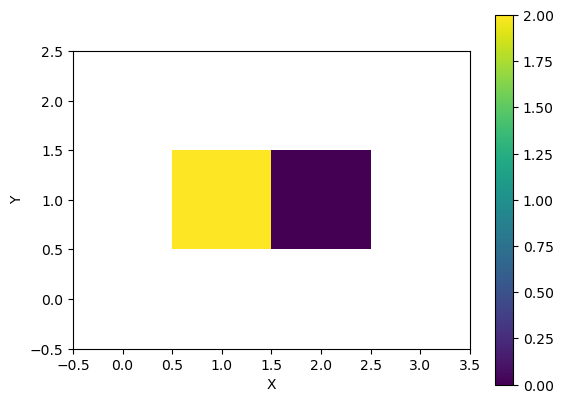

In [371]:
# magic command for showing plots below cell [jupyter notebook only]
%matplotlib inline

# Use im_showgrid to see a 'map' of our two plant functional types
im = imshow_grid(mg, 'vegetation__plant_functional_type', cmap='viridis')

In [372]:
# The SoilMoisture component is largely based on the soil water loss functions from Laio et al. (2001)
# Let's saturate the soil on the first day and watch it drain using the 'update' method.

# Setup lists needed in for loop
rain = [370]+([0] * 365)   # unrealistically high rain pulse with 365 dry days following 
day = []                   # keep track of days since start
sm_grass = []              # relative soil moisture of grass
sm_tree = []               # relative soil moisture of tree
sm_loss_grass = []         # moisture loss per day for grass
sm_loss_tree = []          # moisture loss per day for tree

# March through each day to calculate relative soil moisture state and losses
for i in range(len(rain)):
    # use rain to add water into soil water 'bucket'
    daily_depth = rain[i]
    mg.at_cell['rainfall__daily_depth'][:] = rain[i]
    
    # update conditions based on new rain input
    sm.update()

    # save current values into lists
    # note that we can index both the field in mg and its location at the same time
    day.append(i)
    sm_grass.append(mg.at_cell['soil_moisture__saturation_fraction'][1])
    sm_tree.append(mg.at_cell['soil_moisture__saturation_fraction'][0])
    sm_loss_grass.append(mg.at_cell['surface__evapotranspiration'][1] + mg.at_cell['soil_moisture__root_zone_leakage'][1])
    sm_loss_tree.append(mg.at_cell['surface__evapotranspiration'][0] + mg.at_cell['soil_moisture__root_zone_leakage'][0])

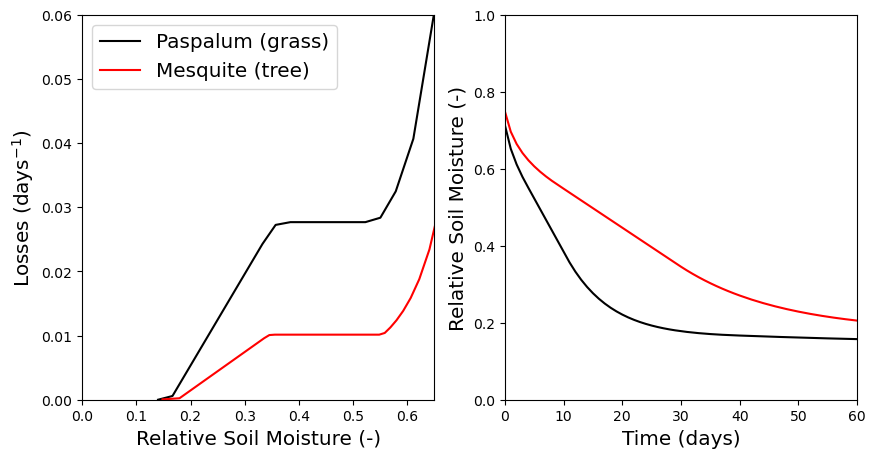

In [373]:
# Plot time series using matplotlib
# Note we will need to convert our losses (in mm) to relative soil moisture using the product of depth and porosity
fig, [ax1, ax2] = plt.subplots(1,2)
ax1.plot(sm_grass, np.divide(sm_loss_grass, 400*0.43), '-k', label='Paspalum (grass)')
ax1.plot(sm_tree, np.divide(sm_loss_tree, 1000*0.43), '-r',  label='Mesquite (tree)')
ax2.plot(day, sm_grass, '-k')
ax2.plot(day, sm_tree, '-r')

# Format axes
ax1.legend(loc='upper left',fontsize='x-large')
ax1.set_xlabel('Relative Soil Moisture (-)', fontsize='x-large')
ax1.set_ylabel('Losses (days$^{-1}$)', fontsize='x-large')
ax1.set(xlim=(0, 0.65), ylim=(0, 0.06))

ax2.set_xlabel('Time (days)', fontsize='x-large')
ax2.set_ylabel('Relative Soil Moisture (-)', fontsize='x-large')
ax2.set(xlim=(0, 60), ylim=(0, 1))

# Set size of figure
fig.set_size_inches(10,5)

<div class="alert alert-block alert-info">
<b>Thought Questions</b><br>
    The figures you just created should look very similar to what is shown in <a href="https://doi.org/10.1016/S0309-1708(01)00005-7"><i>Laio et al. (2001)</i></a>.
<details closed>
<summary>1. How do the two soil water loss functions compare and contrast?</summary>
    <ul><li>Functions capture soil moisture transitions from evaparation only, stressed ET, well-watered ET, and soil leakage.</li>
        <li>Relative water losses for grasses is 2+ times greater for all values of soil moisture.</li>
        <li>This is largely due to differences in the effective soil depth (which is generally higher for trees).</li>
    </ul>
</details>
<details closed>
<summary> 2. Which plant is experiencing more water stress in this unrealistic (364 day drydown) scenario? How can you tell?</summary>
    <ul><li>The right plot shows that soil drying is slower for trees than for grasses. </li></li>
        <li>Given that plant water stress occurs at soil moisture values of ~0.35, the grasses may be more vulnerable. </li>
        <li>But rain is intermittent, so this begs the question as to how plants are adapted to storm sequences. </li>
    </ul>
</details>
</div>

In [374]:
# Now let's consider a sequence of storms
# Set initial condition of soil moisture
mg.at_cell['soil_moisture__initial_saturation_fraction'][:]= 0.14      # hydroscopic point

# Time series for five day-long rainfall events
rain = [140]+([0]*4)+[80]+([0]*19)+[180]+([0]*14)+[10]+([0]*9)+[90]+([0]*9)

# Setup other lists needed in for loop
day = []
sm_grass = []              # relative soil moisture of grass
sm_tree = []               # relative soil moisture of tree
sm_loss_grass = []         # moisture loss per day for grass
sm_loss_tree = []          # moisture loss per day for tree
runoff_grass = []          # surface losses (saturation excess) in grass cell
runoff_tree = []           # surface losses (saturation excess) in tree cell

# March through each day to calculate relative soil moisture state and losses and saturation-excess runoff
for i in range(len(rain)):
    # use rain to add water into soil water 'bucket'
    daily_depth = rain[i]
    mg.at_cell['rainfall__daily_depth'][:] = rain[i]

    # update conditions based on new rain input
    sm.update()

    # save current values into lists
    day.append(i+1)
    sm_grass.append(mg.at_cell['soil_moisture__saturation_fraction'][1])
    sm_tree.append(mg.at_cell['soil_moisture__saturation_fraction'][0])
    sm_loss_grass.append(mg.at_cell['surface__evapotranspiration'][1] + mg.at_cell['soil_moisture__root_zone_leakage'][1])
    sm_loss_tree.append(mg.at_cell['surface__evapotranspiration'][0] + mg.at_cell['soil_moisture__root_zone_leakage'][0])
    runoff_grass.append(mg.at_cell['surface__runoff'][1])
    runoff_tree.append(mg.at_cell['surface__runoff'][0])

# Print out average values of soil moisture and runoff
print(f'Grass Soil Moisture (avg): {np.mean(sm_grass): 0.3f}')
print(f'Tree Soil Moisture (avg): {np.mean(sm_tree): 0.3f}')
print(f'There were {np.count_nonzero(runoff_grass)} days with runoff for grass and {np.count_nonzero(runoff_tree)} days with runoff for trees.')

Grass Soil Moisture (avg):  0.440
Tree Soil Moisture (avg):  0.518
There were 2 days with runoff for grass and 0 days with runoff for trees.


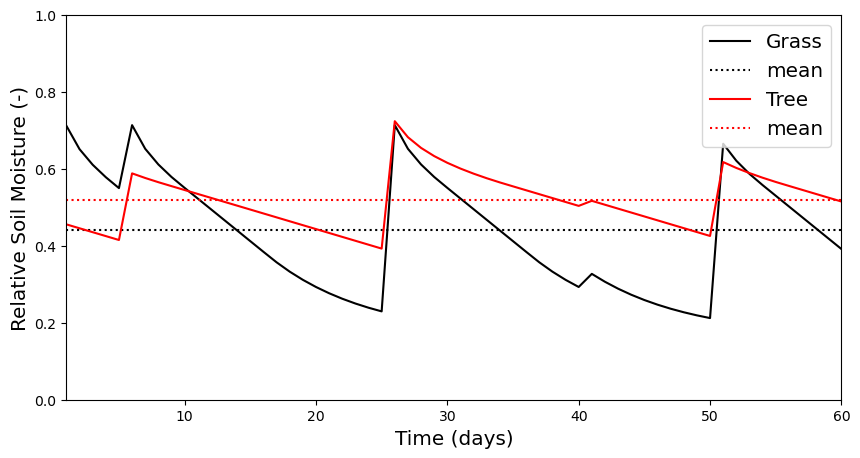

In [375]:
# Plot time series using matplotlib
fig, ax = plt.subplots(1,1)
ax.plot(day, sm_grass, '-k', label='Grass')
ax.plot([1,60],[np.mean(sm_grass), np.mean(sm_grass)],':k', label= 'mean')
ax.plot(day, sm_tree, '-r', label='Tree')
ax.plot([1,60],[np.mean(sm_tree), np.mean(sm_tree)],':r', label='mean')

# Format axes
ax.legend(loc='upper right',fontsize='x-large')
ax.set_xlabel('Time (days)', fontsize='x-large')
ax.set_ylabel('Relative Soil Moisture (-)', fontsize='x-large')
ax.set(xlim=(1, 60), ylim=(0, 1))

# Set size of figure
fig.set_size_inches(10,5)

<div class="alert alert-block alert-info">
<b>Thought Questions</b><br>
    Rain events are easy to spot in the soil moisture data. However, it is not immediately obvious which events and which plant
    functional type will exhibit the highest soil moisture after an event.
<details closed>
<summary>1. How do the two soil water loss functions compare and contrast?</summary>
    <ul><li>Functions capture soil moisture transitions from evaparation only, stressed ET, well-watered ET, and soil leakage.</li>
        <li>Relative water losses for grasses is 2+ times greater for all values of soil moisture.</li>
        <li>This is largely due to differences in the effective soil depth (which is generally higher for trees).</li>
    </ul>
</details>
<details closed>
<summary> 2. What are the advantages and disadvantages to having a deeper soil to hold water?</summary>
    <ul><li>The thinner soil (grass) is 'flashier'. In other  words, it depletes and fills up faster. </li></li>
        <li>The thinner soil (grass) is more likely to produce saturation-excess overland flow. </li>
        <li>The thicker soil (tree) has a higher mean soil moisture than the thinner one (grass). </li>
        <li>The thicker soil (tree) spends more of its time above water stress thresholds. </li>
    </ul>
</details>
</div>

<div class="alert alert-block alert-warning">
<b>Challenge:</b> <i>Can you generate a 60-day series where mean soil moisture is higher for grasses?</i>
<details closed>
<summary> Helpful Hint</summary>
    It is possible, and there is not only one solution to this problem. The previous example highlighted that the tree soil reservoir was slower to deplete.
    What might that mean for how quickly it responds to rainfall inputs once it is depleted?
</details>
<details closed>
<summary> Python code</summary>
    # Now let's consider another sequence of storms<br>
    # Set initial condition of soil moisture<br>
    mg.at_cell['soil_moisture__initial_saturation_fraction'][:]= 0.14      # hydroscopic point<br><br>
    # Time series for different equally spaced events<br>
    rain = ([16.67,0]*30)                     # same total (500 mm); rains every other day<br>
    #rain = ([25,0,0]*20)                     # same total (500 mm); rains every third day<br>
    #rain = ([33.33,0,0,0]*15)                # same total (500 mm); rains every fourth day<br>
    #rain = ([125]+([0]*14))*4                # same total (500 mm); four events<br>
    #rain = ([250]+([0]*29)+[250]+([0]*29))   # same total (500 mm); two events<br><br>
    # Setup other lists needed in for loop<br>
    day = []<br>
    sm_grass = []              # relative soil moisture of grass<br>
    sm_tree = []               # relative soil moisture of tree<br>
    sm_loss_grass = []         # moisture loss per day for grass<br>
    sm_loss_tree = []          # moisture loss per day for tree<br>
    runoff_grass = []          # surface losses (saturation excess) in grass cell<br>
    runoff_tree = []           # surface losses (saturation excess) in tree cell<br><br>
    # March through each day to calculate relative soil moisture state and losses and saturation-excess runoff<br>
    for i in range(len(rain)):<br>
        # use rain to add water into soil water 'bucket'<br>
        daily_depth = rain[i]<br>
        mg.at_cell['rainfall__daily_depth'][:] = rain[i]<br><br>
        # update conditions based on new rain input<br>
        sm.update()<br><br>
        # save current values into lists<br>
        day.append(i+1)<br>
        sm_grass.append(mg.at_cell['soil_moisture__saturation_fraction'][1])<br>
        sm_tree.append(mg.at_cell['soil_moisture__saturation_fraction'][0])<br>
        sm_loss_grass.append(mg.at_cell['surface__evapotranspiration'][1] + mg.at_cell['soil_moisture__root_zone_leakage'][1])<br>
        sm_loss_tree.append(mg.at_cell['surface__evapotranspiration'][0] + mg.at_cell['soil_moisture__root_zone_leakage'][0])<br>
        runoff_grass.append(mg.at_cell['surface__runoff'][1])<br>
        runoff_tree.append(mg.at_cell['surface__runoff'][0])<br><br>
    # Print out average values of soil moisture and runoff<br>
    print(f'Grass Soil Moisture (avg): {np.mean(sm_grass): 0.3f}')<br>
    print(f'Tree Soil Moisture (avg): {np.mean(sm_tree): 0.3f}')<br>
    print(f'There were {np.count_nonzero(runoff_grass)} days with runoff for grass and {np.count_nonzero(runoff_tree)} days with runoff for trees.')<br><br>
    # Plot time series using matplotlib<br>
    fig, ax = plt.subplots(1,1)<br>
    ax.plot(day, sm_grass, '-k', label='Grass')<br>
    ax.plot([1,60],[np.mean(sm_grass), np.mean(sm_grass)],':k', label= 'mean')<br>
    ax.plot(day, sm_tree, '-r', label='Tree')<br>
    ax.plot([1,60],[np.mean(sm_tree), np.mean(sm_tree)],':r', label='mean')<br><br>
    # Format axes<br>
    ax.legend(loc='upper right',fontsize='x-large')<br>
    ax.set_xlabel('Time (days)', fontsize='x-large')<br>
    ax.set_ylabel('Relative Soil Moisture (-)', fontsize='x-large')<br>
    ax.set(xlim=(1, 60), ylim=(0, 1))<br><br>
    # Set size of figure<br>
    fig.set_size_inches(10,5)<br><br>
    # A couple things to note<br>
    # 1. Once both soil water buckets are full, soil moisture evolves to a similar mean state (though grass is still flashier).<br>
    # 2. In these examples, soils spend a lot of their time at or above field capacity.<br>
    # 3. The mean soil moisture is lower for the trees largely because it takes a longer time for smaller storms to fill up the soil water bucket.<br>
    # 4. Examples highlight that larger storms that saturate the tree erase this contrast and, in fact, lead to more water lost via surface runoff.<br>
    # 5. Difference in response times suggests that grasses may be more responsive to increased rainstorm frequency after prolongued drying.<br>
</details>
</div>

In [376]:
# 60-day series where mean soil moisture is higher for grasses
# Set initial condition of soil moisture

# Time series for different equally spaced events

# Setup other lists needed in for loop

# March through each day to calculate relative soil moisture state and losses and saturation-excess runoff

# Print out average values of soil moisture and runoff

# Plot time series using matplotlib

# Format axes

# Set size of figure


## 2.2 Coupling Landlab components
[Overview](#Overview) &nbsp; &nbsp; [2.1 Dynamic soil moisture](#2.1-Dynamic-soil-moisture) &nbsp; &nbsp; __[2.2 Coupling Landlab components](#2.2-Coupling-Landlab-components)__ &nbsp; &nbsp; [2.3 Routing surface water](#2.3-Routing-surface-water) &nbsp; &nbsp; [Definitions](#Definitions)

> The strength of Landlab is that it makes it easier to couple different process components on a common model grid. For example, you've now been introduced to a component that generates stochastic rainfall (Chapter 1) and and a component that calculates soil moisture as a function of daily precipitation (Section 2.1). In this section, you will couple these two components together.

> Because the soil water model was designed for daily rainfall inputs, we will first use PrecipitationDistribution to generate a time series that we can resample to a daily time step. Daily storm depths will serve as an input into SoilMoisture. Using  this simple model configuration, we will generate a probability ditribution of soil moisture states for two different plant functional types (i.e., grass versus trees) experiencing the same rainfall.

<div class="alert alert-block alert-info">
<b>Stochastic Rainfall Generators</b><br>In the examples above, we manually set up a sequence of storms to see help understand the dynamics of the <a href="https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html"><i>SoilMoisture</i></a> component. However, we already saw in the previous chapter that rainstorms can be stochastic (i.e., have a random element). The Poisson rectangular pulse is one probability distribution that has been used in landscape veolution studies and is already included as a Landlab component, called <a href="https://landlab.readthedocs.io/en/latest/reference/components/uniform_precip.html"><i>PrecipitationDistribution</i></a>. This rainfall generator can be used in a couple of different ways: 1. Generate a time series of events all at onces for a specified time period, or 2. Generate one event at a time using the specified distribution parameters. This latter choice can be useful if you don't want to keep a long time series of rainfall in memory for the entire model run and is the approach we take below.<br><br>It is worth noting that the default behavior for the rainfall generator is to use a a different pseudo-random seed every time you run the code block. This means that you will get a different result every time. We will exploit this behavior to examine how results our sensitive to the intrinsic stochasticity of the system. However, you will notice there is an option to fix the pseudo-random seed commented out. When testing your code and/or building a reproducible workflow, it can be helpful to keep the input unchanged.
</div>

In [377]:
# Set stochastic parameters for precipitation generator
tt_days = 365               # total time in days
tt = tt_days*24             # total time in hours
storm_intensity = 12       # mm/hr
storm_duration = 4          # hrs
interstorm_duration = 300   # hrs

# Derive expected mean annual precipitation
# Note this will be different from time series because this is what is expected 'on average'
map_expected = ((storm_intensity * storm_duration) / (storm_duration + interstorm_duration)) * 24 * 365

# Print out average values of soil moisture and runoff
print(f'Expected mean annual precipitation: {map_expected: 0.1f} mm/yr')

Expected mean annual precipitation:  1383.2 mm/yr


In [378]:
# Instantiate component
rain = PrecipitationDistribution(total_t=tt, mean_storm_duration=storm_duration, 
                          mean_interstorm_duration=interstorm_duration, 
                          mean_storm_depth=storm_intensity*storm_duration)

In [379]:
# Let's get a feel for what the generator 'yield_storm_interstorm_duration_intensity' provides
#rain.seed_generator(seedval=1)       # use if you want the same sequence every time
for (interval_duration, rainfall_rate) in rain.yield_storm_interstorm_duration_intensity():
    print(f'{interval_duration: 0.2f} hrs at{rainfall_rate: 0.2f} mm/hr.')

 2.18 hrs at 13.40 mm/hr.
 89.89 hrs at 0.00 mm/hr.
 2.86 hrs at 33.49 mm/hr.
 155.72 hrs at 0.00 mm/hr.
 6.13 hrs at 3.93 mm/hr.
 108.43 hrs at 0.00 mm/hr.
 2.59 hrs at 9.05 mm/hr.
 262.68 hrs at 0.00 mm/hr.
 9.55 hrs at 13.50 mm/hr.
 210.77 hrs at 0.00 mm/hr.
 1.32 hrs at 17.25 mm/hr.
 422.94 hrs at 0.00 mm/hr.
 3.85 hrs at 10.85 mm/hr.
 86.51 hrs at 0.00 mm/hr.
 9.62 hrs at 13.83 mm/hr.
 1218.60 hrs at 0.00 mm/hr.
 6.65 hrs at 12.76 mm/hr.
 697.34 hrs at 0.00 mm/hr.
 1.49 hrs at 27.20 mm/hr.
 392.61 hrs at 0.00 mm/hr.
 9.16 hrs at 8.30 mm/hr.
 345.59 hrs at 0.00 mm/hr.
 2.56 hrs at 0.30 mm/hr.
 31.84 hrs at 0.00 mm/hr.
 2.28 hrs at 16.03 mm/hr.
 283.17 hrs at 0.00 mm/hr.
 9.77 hrs at 41.28 mm/hr.
 1019.82 hrs at 0.00 mm/hr.
 2.59 hrs at 2.21 mm/hr.
 601.43 hrs at 0.00 mm/hr.
 1.21 hrs at 27.81 mm/hr.
 490.47 hrs at 0.00 mm/hr.
 3.18 hrs at 26.82 mm/hr.
 4.24 hrs at 0.00 mm/hr.
 5.09 hrs at 4.33 mm/hr.
 152.66 hrs at 0.00 mm/hr.
 6.97 hrs at 1.00 mm/hr.
 330.92 hrs at 0.00 mm/hr.
 0.

In [380]:
# In simulating storms, we chose hours as a useful unit to describe events.
# We are going to need to harmonize this with the soil moisture component which operates at the daily time step.

# First, set initial condition of soil moisture
mg.at_cell['soil_moisture__initial_saturation_fraction'][:]= 0.14      # hydroscopic point

# Setup empty lists to save outputs in 'for loop'
depths = []                # daily depths (mm)
sm_grass = []              # relative soil moisture of grass (-)
sm_tree = []               # relative soil moisture of tree (-)
sm_loss_grass = []         # moisture loss per day for grass (-)
sm_loss_tree = []          # moisture loss per day for tree (-)
runoff_grass = []          # surface losses (saturation excess) in grass cell (mm)
runoff_tree = []           # surface losses (saturation excess) in tree cell (mm)

# Set variables used in 'for loop' to zero
duration = 0
depth = 0
pdur = 0
pdep = 0

# Model will only calculate soil moisture at 24 hour intervals using values of 'interval_duration' and 'rainfall_rate' and values from previous step
for (interval_duration, rainfall_rate) in rain.yield_storm_interstorm_duration_intensity():
    
    # duration is sum of current duration and the remainder of time from previous step 
    duration = interval_duration + pdur

    # add values from this interval to previous if still less than 24 hours
    if duration < 24:
        pdep += interval_duration * rainfall_rate
        pdur += duration

    # use while loop to run soil moisture component for every 24 hour increment
    else:
        while duration >= 24:
            depth = pdep + (rainfall_rate * (24 - pdur))
            duration -= 24
            pdep = 0
            pdur = 0

            # only update soil moisture at 24 hour increments; record daily depths
            mg.at_cell['rainfall__daily_depth'][:] = depth
            depths.append(depth)
            sm.update()

            # save current state into lists
            sm_grass.append(mg.at_cell['soil_moisture__saturation_fraction'][1])
            sm_tree.append(mg.at_cell['soil_moisture__saturation_fraction'][0])
            sm_loss_grass.append(mg.at_cell['surface__evapotranspiration'][1] + mg.at_cell['soil_moisture__root_zone_leakage'][1])
            sm_loss_tree.append(mg.at_cell['surface__evapotranspiration'][0] + mg.at_cell['soil_moisture__root_zone_leakage'][0])
            runoff_grass.append(mg.at_cell['surface__runoff'][1])
            runoff_tree.append(mg.at_cell['surface__runoff'][0])

        # save remainder of depths and durations for next iteration
        pdep = duration * rainfall_rate
        pdur = duration

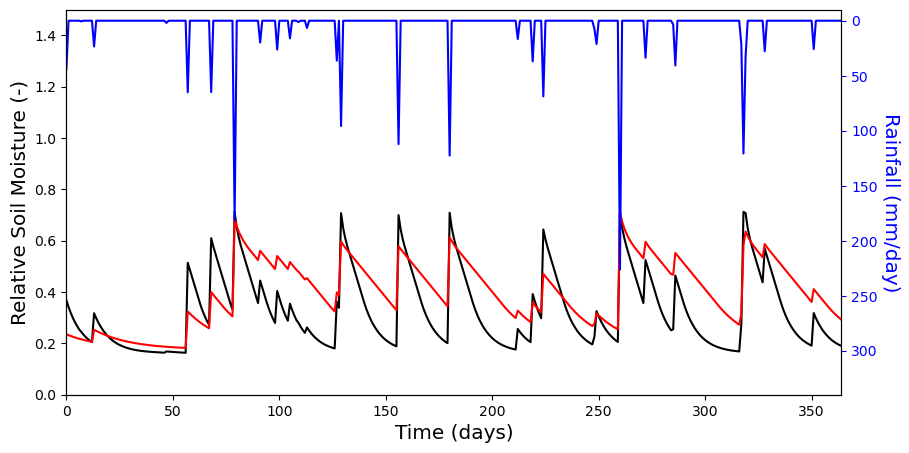

In [381]:
# Plot time series using matplotlib
fig, ax1 = plt.subplots(1,1)
ax1.plot(sm_grass, '-k', label='Grass')
ax1.plot(sm_tree, '-r', label='Tree')

# Use twin axis to create double-y plot
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(depths, color='b')

# Format axes
ax1.set_xlabel('Time (days)', fontsize='x-large')
ax1.set_ylabel('Relative Soil Moisture (-)', fontsize='x-large')
ax1.set(xlim=(0,tt_days-1), ylim=(0,1.5))
ax2.set_ylabel('Rainfall (mm/day)', color='b', rotation=270, labelpad=16, fontsize='x-large')
ax2.tick_params(axis='y', colors='b')
ax2.set(xlim=(0,tt_days-1), ylim=(-10,340))
plt.gca().invert_yaxis()      # rainfall increases downward so we can compare events

# Set size of figure
fig.set_size_inches(10,5)

<div class="alert alert-block alert-warning">
<b>Challenge:</b> <i>Run the model 10 times to see how soil moisture and runoff statistics change from year to year.</i>
    
<details closed>
<summary> Helpful Hint</summary>
    <ol><li>Set up the <b>variables</b> you want to save.</li>
        <li>Place the results in a pandas dataframe using a unique index (i.e., <i>dataframe.loc[index]</i>) to <b>store</b> your results.</li>
        <li>Run your model (above) again, and do the same thing <b>10 times</b>.</li>
        <li>Use the <i>dataframe.describe()</i> method to <b>summarize</b> the statistics for your 10 trials.</li>
    </ol>
</details>

<details closed>
<summary> Python code</summary>
  

</div>div>

In [383]:
# We haven't used pandas in this chapter yet, so let's import it
import pandas as pd

# Dictionary of table headers
headers = {'Mean Rainfall (mm/yr)': [],'Grass Moisture (-)': [], 'Grass Runoff (mm/yr)': [], 'Grass Runoff Ratio (-)': [], 'Tree Moisture (-)': [], 'Tree Runoff (mm/yr)': [], 'Tree Runoff Ratio (-)': []}

# Empty pandas dataframe called 'table'
table = pd.DataFrame(data=headers)

In [384]:
# Run model 10 times and store results in the pandas dataframe you just created
# Set initial condition of soil moisture

# Setup empty lists to save outputs in 'for loop'

# Set variables used in 'for loop' to zero

# Model will only calculate soil moisture at 24 hour intervals using values of 'interval_duration' and 'rainfall_rate' and values from previous step

# Store results using table.loc[index]

# When done with trials, print out pandas dataframe 'table'

# Summarize results using table.describe()

## 2.3 Routing surface water
[Overview](#Overview) &nbsp; &nbsp; [2.1 Dynamic soil moisture](#2.1-Dynamic-soil-moisture) &nbsp; &nbsp; [2.2 Coupling Landlab components](#2.2-Coupling-Landlab-components) &nbsp; &nbsp; __[2.3 Routing surface water](#2.3-Routing-surface-water)__ &nbsp; &nbsp; [Definitions](#Definitions)

> Up to now, our numerical simulations do not include the lateral transport of water. Rain simply __[infiltrates](#Definitions)__ the surface and increases relative __[soil moisture](#Definitions)__. This is a fine approximation of the surface water hydrology on shallow slopes where there is not much __[overland flow](#Definitions)__. However, if surface (or subsurface) water starts flowing, then this 'local' description of soil water state will be incomplete. Given that water flows downhill under the force of gravity, a very simple approximation for how water accumulates downhill is to use topography to calculate the flow direction and flow accumulation. Note that this approach does not account for the time that it takes for water to accumulate and frictional resistance the surface provides to slow it down.
>
> This section introduces you one of a few of the flow direction calcuators that Landlab includes, namely the _[FlowDirectorSteepest](https://landlab.readthedocs.io/en/latest/reference/components/flow_director.html)_ component. These flow directors underlie the _[FlowAccumulator](https://landlab.readthedocs.io/en/latest/reference/components/flow_accum.html)_ that can be used to calculate drainage area and discharge.

In [385]:
# Import some new components
from landlab.components import FlowDirectorSteepest
from landlab.components import FlowAccumulator

# useful utility to map from nodes to cells
from landlab.grid.mappers import map_node_to_cell

# Import a handy plotting utility to help us visualize the flow
from landlab.plot.drainage_plot import drainage_plot

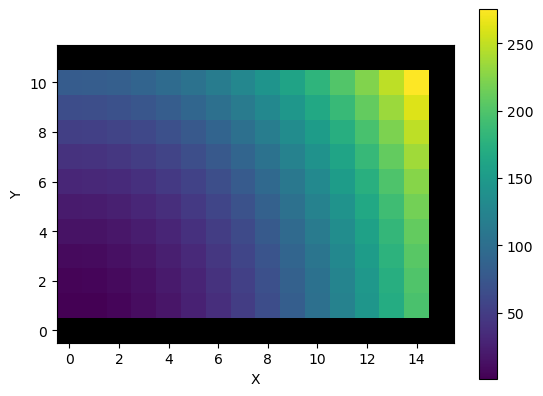

In [386]:
# Let's build a somewhat larger grid to get a feel for how these new components work
nrows = 12
ncols = 16
dxy = 1
mg = RasterModelGrid((nrows, ncols), xy_spacing=dxy)

# Let's close some boundaries
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True, top_is_closed=True, left_is_closed=False, bottom_is_closed=True)

# Add topographic elevation to our model grid
mg.add_zeros('topographic__elevation', at = 'node', clobber=True)
mg.at_node['topographic__elevation'] = mg.x_of_node**2 + mg.y_of_node**1.9              # highest point in top right, lowest in bottom left; slight steeper in x-direction 

# Use im_showgrid to see a 'map' elevations
im = imshow_grid(mg, 'topographic__elevation', cmap='viridis')

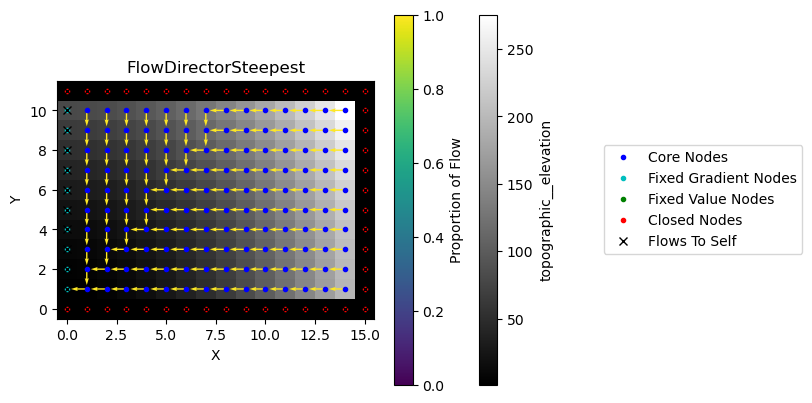

In [387]:
# Instantiate flow director
fd = FlowDirectorSteepest(mg, 'topographic__elevation')

# This method determines flow directions and save them to model grid
fd.run_one_step()

# Use drainage plot to visualize model grid flow
plt.figure()
drainage_plot(mg, title='FlowDirectorSteepest')

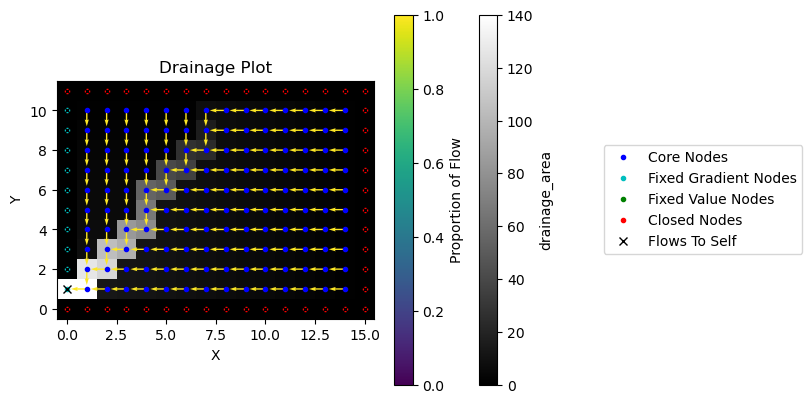

In [388]:
# Now let's look at what the FlowAccumulator does
fa = FlowAccumulator(mg, surface='topographic__elevation')

# This method determines accumulates flow and saves it to model grid
fa.run_one_step()

# Use drainage plot to visualize model grid accumulation
plt.figure()
drainage_plot(mg, 'drainage_area')

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


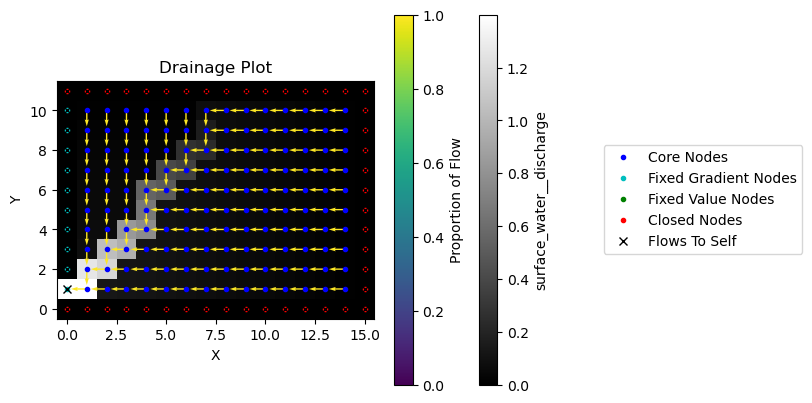

In [389]:
# Now let's look at what the FlowAccumulator does when we give it a runoff rate
fa = FlowAccumulator(mg, surface='topographic__elevation', runoff_rate=0.01)

# This method determines accumulates flow and saves it to model grid
fa.run_one_step()

# Use drainage plot to visualize model grid accumulation
plt.figure()
drainage_plot(mg, 'surface_water__discharge')

# This should look equivalent to drainage area since we used a uniform runoff rate.
# Note that this has now been scaled

In [390]:
# Now lets go back to our original 2-cell grid
# Let's build our first Landlab model grid (12 nodes with 2 cells)
nrows = 3
ncols = 4
dxy = 1
mg = RasterModelGrid((nrows, ncols), xy_spacing=dxy)

# Add the input fields to our model grid
mg.add_zeros('rainfall__daily_depth', at = 'cell')                         # mm
mg.add_zeros('soil_moisture__initial_saturation_fraction', at = 'cell')    # -  (volume water / volume pore spaces)
mg.add_zeros('surface__potential_evapotranspiration_rate', at = 'cell')    # mm/day
mg.add_zeros('vegetation__cover_fraction', at = 'cell')                    # -  (area of veg / area of ground)
mg.add_zeros('vegetation__live_leaf_area_index', at = 'cell')              # -  (area of canopy / area of ground)
mg.add_zeros('vegetation__plant_functional_type',at = 'cell', dtype=int)   # categorical (grass=0, shrub=1, tree=2, bare=3, shrub_seedling=4, tree_seedling=5)
mg.add_zeros('topographic__elevation', at = 'node', clobber=True)          # m
run = mg.add_zeros('local__runoff', at = 'node', clobber=True)            # m/dy

# We added zeros to initialize fields, but let's actually place some values in them
mg.at_cell['rainfall__daily_depth'][:] = 0                                 # we will be changing this value a lot 
mg.at_cell['soil_moisture__initial_saturation_fraction'][:] = 0.14         # hydroscopic point where no evaporation occurs          
mg.at_cell['surface__potential_evapotranspiration_rate'][:] = 4.76         # grass - Paspalum setaceum (Laio et al., 2001)
mg.at_cell['vegetation__cover_fraction'][:]= 1.0                           # full vegetation cover
mg.at_cell['vegetation__live_leaf_area_index'][:]= 2.88                    # reference value for grass
mg.at_cell['vegetation__plant_functional_type'][:]= [2,0]                  # two plants [grass=0, shrub=1, tree=2, bare=3, shrub_seedling=4, tree_seedling=5]
mg.at_node['topographic__elevation'] = mg.x_of_node**2 + mg.y_of_node**1.9 # like before

In [391]:
# Set stochastic parameters for precipitation generator
tt_days = 365               # total time in days
tt = tt_days*24             # total time in hours
storm_intensity = 12       # mm/hr
storm_duration = 4          # hrs
interstorm_duration = 300   # hrs

In [392]:
# Instantiate all of our components
rain = PrecipitationDistribution(total_t=tt, mean_storm_duration=storm_duration, 
                          mean_interstorm_duration=interstorm_duration, 
                          mean_storm_depth=storm_intensity*storm_duration)

sm = SoilMoisture(mg, zr_grass=0.4, zr_tree=1.0, pc_grass=0.43, pc_tree=0.43, fc_grass=0.56, fc_tree=0.56, 
                  sc_grass=0.37, sc_tree=0.35, wp_grass=0.167, wp_tree=0.18, hgw_grass=0.14, hgw_tree=0.14, 
                  beta_grass=13.8, beta_tree=13.8) 

# Now let's look at what the FlowAccumulator does when we give it a runoff rate
fa = FlowAccumulator(mg, surface='topographic__elevation', runoff_rate='local__runoff')

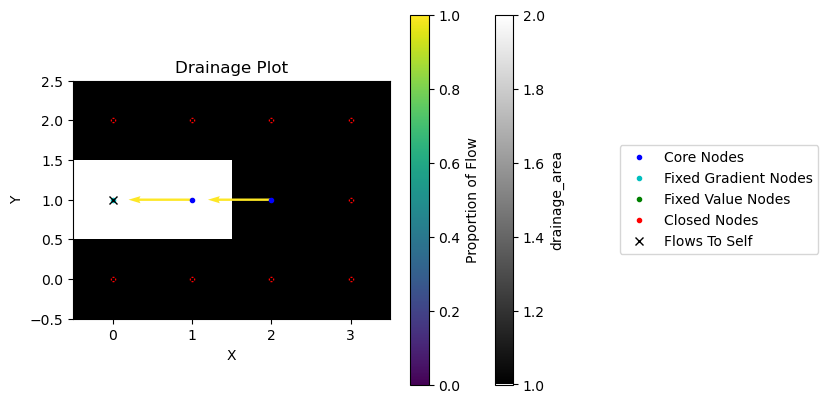

In [393]:
# Let's close some boundaries
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True, top_is_closed=True, left_is_closed=False, bottom_is_closed=True)

# This method determines accumulates flow and saves it to model grid
fa.run_one_step()

# Use drainage plot to visualize model grid accumulation
plt.figure()
drainage_plot(mg, 'drainage_area')
# Should now have a very simple slope with highest elevations in the grass cell (right), and with just one boundary node open.

<div class="alert alert-block alert-info">

#### __Landlab Grids__ - raster edition v2
This simple grid illustrates the importance of boundary conditions, especially when doing calculations along links. By keeping only the left boundary node open, we created a flow direction network two links long that flows out of the left boundary. If we had closed all the boundary nodes, the flow direction network would only be one link long between the two core nodes. If we had opened up the bottom boundary nodes, then the two core nodes would not flow into each other and would instead flow out the bottom of the grid. Try running the cells above to check for yourself and develop an intuition for how the boundary condtions constrain your flow network.
</div>

In [394]:
# In simulating storms, we chose hours as a useful unit to describe events.
# We are going to need to harmonize this with the soil moisture component which operates at the daily time step.

# First, set initial condition of soil moisture
mg.at_cell['soil_moisture__initial_saturation_fraction'][:]= 0.14      # hydroscopic point

# Setup empty lists to save outputs in 'for loop'
depths = []                # daily depths (mm)
sm_grass = []              # relative soil moisture of grass (-)
sm_tree = []               # relative soil moisture of tree (-)
sm_loss_grass = []         # moisture loss per day for grass (-)
sm_loss_tree = []          # moisture loss per day for tree (-)
runoff_grass = []          # surface losses (saturation excess) in grass cell (mm)
runoff_tree = []           # surface losses (saturation excess) in tree cell (mm)

# Set variables used in 'for loop' to zero
duration = 0
depth = 0
pdur = 0
pdep = 0

# Model will only calculate soil moisture at 24 hour intervals using values of 'interval_duration' and 'rainfall_rate' and values from previous step
for (interval_duration, rainfall_rate) in rain.yield_storm_interstorm_duration_intensity():
    
    # duration is sum of current duration and the remainder of time from previous step 
    duration = interval_duration + pdur

    # add values from this interval to previous if still less than 24 hours
    if duration < 24:
        pdep += interval_duration * rainfall_rate
        pdur += duration

    # use while loop to run soil moisture component for every 24 hour increment
    else:
        while duration >= 24:
            depth = pdep + (rainfall_rate * (24 - pdur)) + run[mg.core_nodes]
            duration -= 24
            pdep = 0
            pdur = 0

            # only update soil moisture at 24 hour increments; record daily depths
            mg.at_cell['rainfall__daily_depth'][:] = depth
            depths.append(depth)
            sm.update()
            run[mg.core_nodes] = mg.at_cell['surface__runoff']
            fa.run_one_step()

            # save current state into lists
            sm_grass.append(mg.at_cell['soil_moisture__saturation_fraction'][1])
            sm_tree.append(mg.at_cell['soil_moisture__saturation_fraction'][0])
            sm_loss_grass.append(mg.at_cell['surface__evapotranspiration'][1] + mg.at_cell['soil_moisture__root_zone_leakage'][1])
            sm_loss_tree.append(mg.at_cell['surface__evapotranspiration'][0] + mg.at_cell['soil_moisture__root_zone_leakage'][0])
            runoff_grass.append(mg.at_cell['surface__runoff'][1])
            runoff_tree.append(mg.at_cell['surface__runoff'][0])

        # save remainder of depths and durations for next iteration
        pdep = duration * rainfall_rate
        pdur = duration

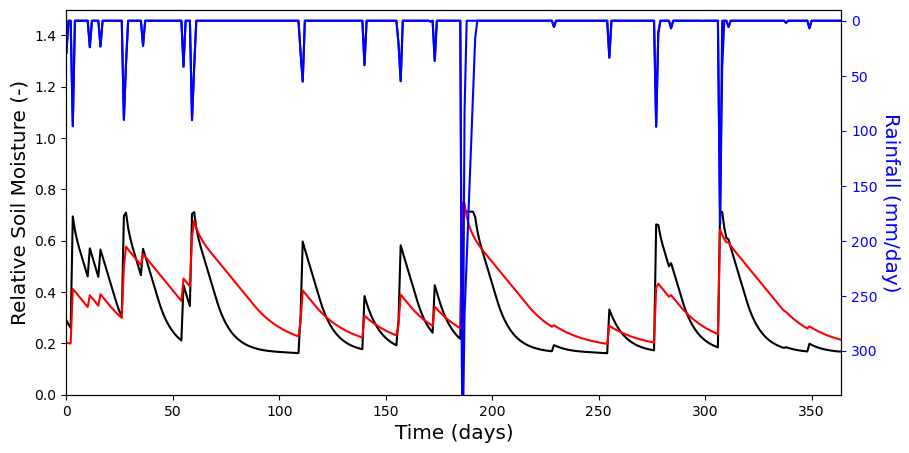

In [395]:
# Plot time series using matplotlib
fig, ax1 = plt.subplots(1,1)
ax1.plot(sm_grass, '-k', label='Grass')
ax1.plot(sm_tree, '-r', label='Tree')

# Use twin axis to create double-y plot
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(depths, color='b')

# Format axes
ax1.set_xlabel('Time (days)', fontsize='x-large')
ax1.set_ylabel('Relative Soil Moisture (-)', fontsize='x-large')
ax1.set(xlim=(0,tt_days-1), ylim=(0,1.5))
ax2.set_ylabel('Rainfall (mm/day)', color='b', rotation=270, labelpad=16, fontsize='x-large')
ax2.tick_params(axis='y', colors='b')
ax2.set(xlim=(0,tt_days-1), ylim=(-10,340))
plt.gca().invert_yaxis()      # rainfall increases downward so we can compare events

# Set size of figure
fig.set_size_inches(10,5)

<div class="alert alert-block alert-warning">
<b>Challenge:</b> <i>Run the model 10 times to see how soil moisture and runoff statistics change from year to year.</i>
    
<details closed>
<summary> Helpful Hint</summary>
    <ol><li>Set up the <b>variables</b> you want to save.</li>
        <li>Place the results in a pandas dataframe using a unique index (i.e., <i>dataframe.loc[index]</i>) to <b>store</b> your results.</li>
        <li>Run your model (above) again, and do the same thing <b>10 times</b>.</li>
        <li>Use the <i>dataframe.describe()</i> method to <b>summarize</b> the statistics for your 10 trials.</li>
    </ol>
</details>

<details closed>
<summary> Python code</summary>
    
</details>

</div>div>

### You have now completed Chapter 2

Continue on to [Chapter 3: But will the hillslope fail?](./Chapter-3.ipynb)

## Definitions
[Overview](#Overview) &nbsp; &nbsp; [2.1 Dynamic soil moisture](#2.1-Dynamic-soil-moisture) &nbsp; &nbsp; [2.2 Coupling Landlab components](#2.2-Coupling-Landlab-components) &nbsp; &nbsp; [2.3 Routing surface water](#2.3-Routing-surface-water) &nbsp; &nbsp; __[Definitions](#Definitions)__

__evapotranspiration__:<br>
> Evaporation and transpiration can flux water at or near the surface back into the atmosphere. The former refers to the flux that occurs where air is in direct contact with liquid water. The latter refers to the flux that is mediated by plants. 

__hydraulic conductivity__:<br>
> A property of porous materials that descibes the rate at which water can flow. It depends on the permeability (material property), saturation state, and on fluid properties (e.g., viscosity).

__infiltration__:<br>
> The process by which water moves downward into and through permeable materials (e.g., soil).

__infiltration capacity__:<br>
> The maximum rate in which water can move downward into a porous material. It depends both on material properties and saturation state.

__infiltration-excess overland flow__:<br>
> Surface runoff that is generated when the infiltration capacity is exceeded. It is sometimes referred to as Horton overland flow.

__permeability__:<br>
> The ability of a material to allow fluids to flow through it. It is sometimes referred to as intrinsic permeability to clarify that it is referring to a property of the substrate (and not the fluids moving through it). 

__plant functional type__:<br>
> A simplification of the role of plants such that complexities in plant physiology are reduced to a shared set of functional responses (e.g., photosynthesis) to driving variables (e.g., water inputs). 

__porosity__:<br>
> The fraction of void spaces in rock or soil that can be filled with water or air (or other fluids).

__runoff__:<br>
> The portion of precipitation that reaches rivers, lakes, and oceans. Most precipitation goes to evapotranspiration, some is stored in the subsurface, and the rest makes up runoff.

__saturation-excess overland flow__:<br>
> Surface runoff that is generated when the soil is fully saturated. It is sometimes referred to as Dunne runoff.

__soil moisture__:<br>
> The water content of soil. It can be measured in units of volume, mass, or as a relative measure. For instance, in this chapter soil moisture is normalized by the maximum amout liquid water that can be stored in the plant root zone (i.e., varies between 0 and 1).

__soil texture__:<br>
> A classification scheme that soils that provides a description of soils in terms of the relative fractions of different grain sizes (i.e., sand, silt, clay).